In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_color_codes()

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=12)

pal = sns.color_palette()

### Interaction between a binary and a continuous variable

In [6]:
rugged = pd.read_csv('data/rugged.csv', sep=';')
# log version of outcome - real gross domestic product per capita
rugged['log_gdp'] = np.log(rugged['rgdppc_2000'])

# keep only countries with GDP data
dd = rugged.loc[rugged.rgdppc_2000.notnull()]

# show only relevant variables
dd[['rugged', 'rgdppc_2000', 'log_gdp', 'cont_africa']].head()

,rugged,rgdppc_2000,log_gdp,cont_africa
2,0.858,1794.729,7.492609,1
4,3.427,3703.113,8.216929,0
7,0.769,20604.460,9.933263,0
8,0.775,12173.680,9.407032,0
9,2.688,2421.985,7.792343,0


In [7]:
dd.shape

(170, 52)

We model the log(GDP) as a function of the terrain ruggedness, and add an interaction between `cont_africa` (if the country is in Africa or not) and `rugged`. 

In [8]:
with pm.Model() as interact_model:
    alpha = pm.Normal('alpha', mu=8, sd=100)
    beta_a = pm.Normal('beta_a', mu=0, sd=1)
    beta_r = pm.Normal('beta_r', mu=0, sd=1)
    beta_ar = pm.Normal('beta_ar', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    gamma = beta_r + beta_ar * dd.cont_africa
    mu = alpha + gamma * dd.rugged + beta_a * dd.cont_africa
    log_gdp_hat = pm.Normal('log_gdp_hat', mu, sigma, observed=dd.log_gdp)
    log_gdp_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/nshenkov/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1500/1500 [00:02<00:00, 651.41it/s]


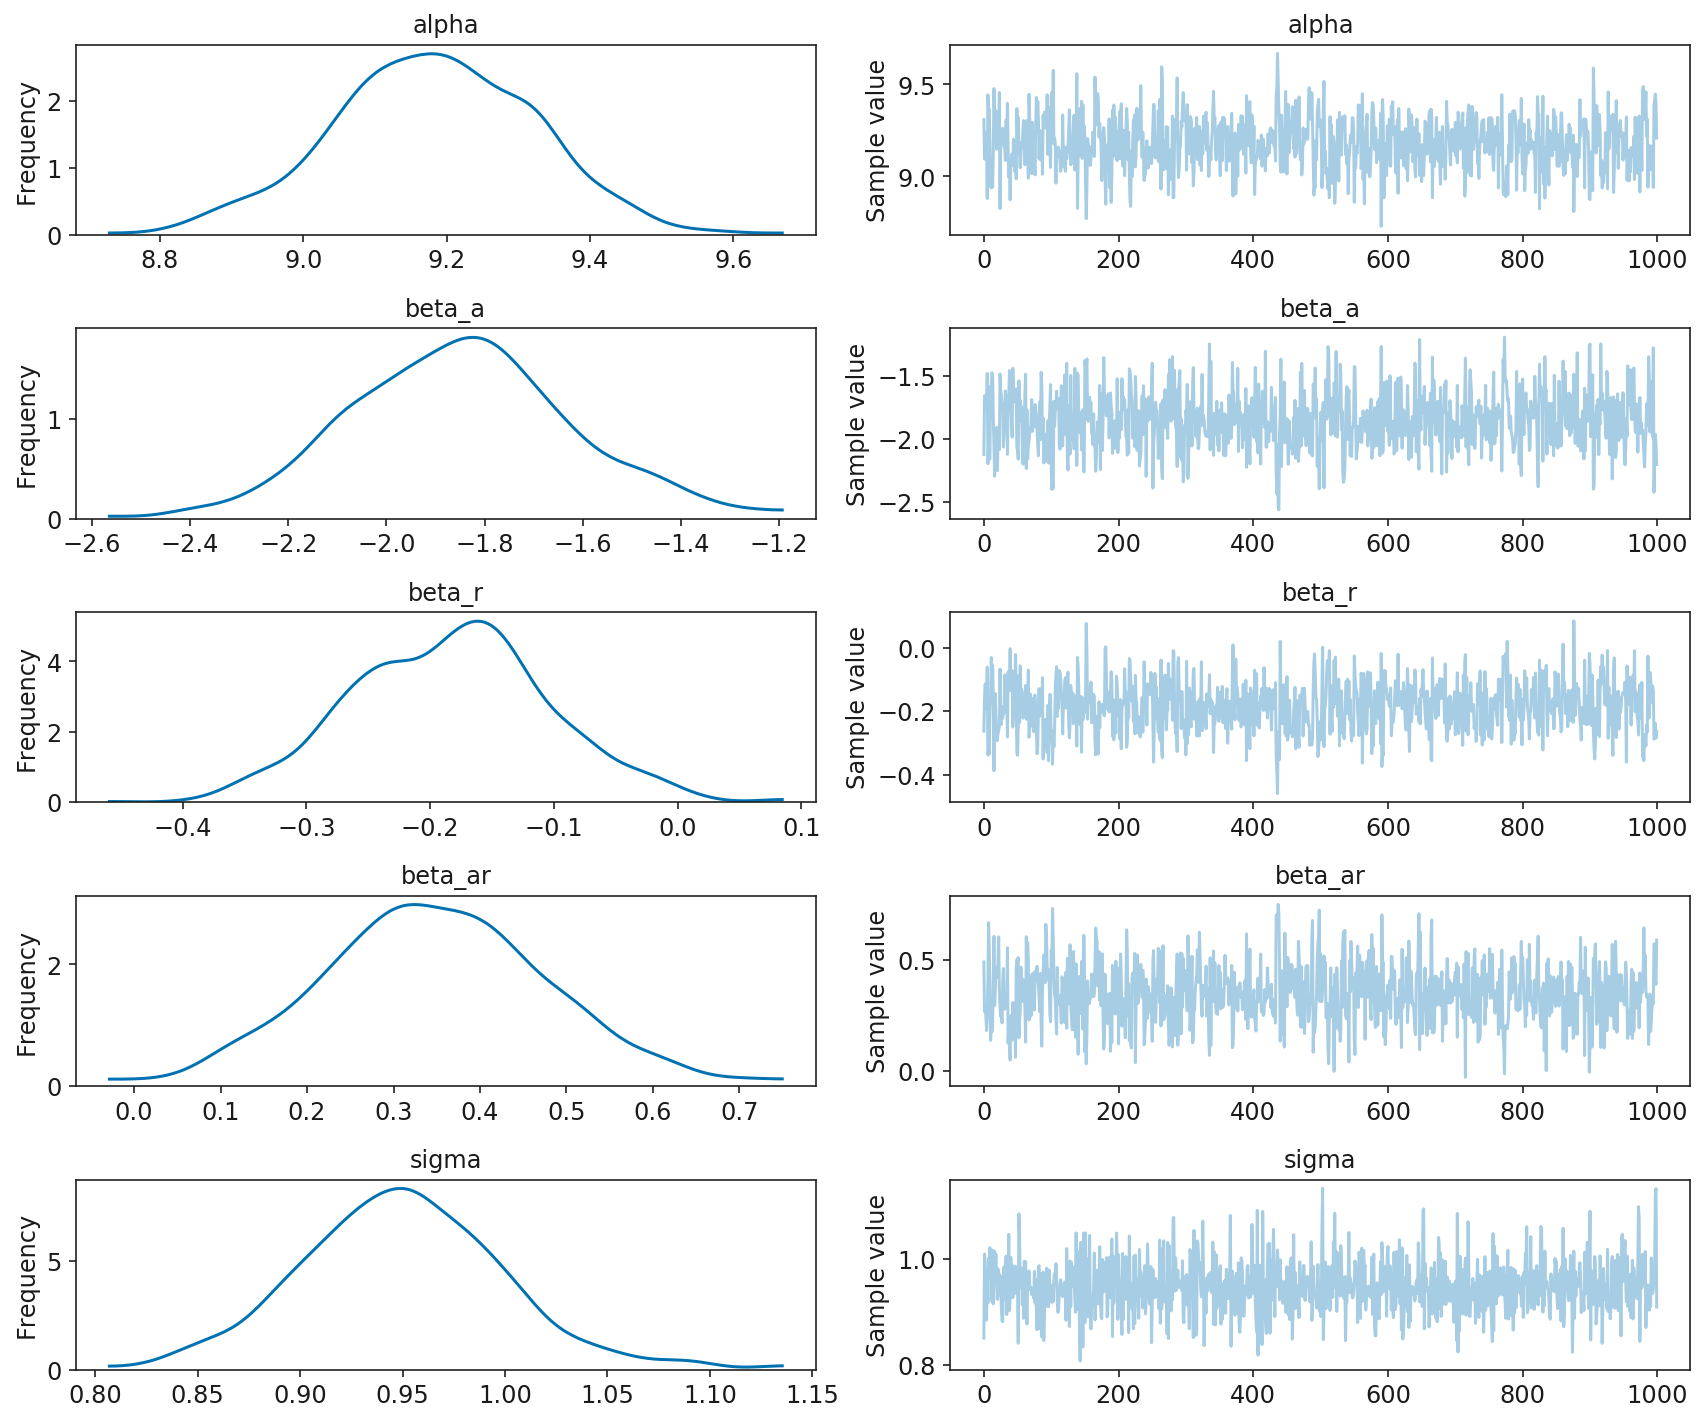

In [9]:
pm.traceplot(log_gdp_trace);

In [10]:
log_gdp_df = pm.trace_to_dataframe(log_gdp_trace)

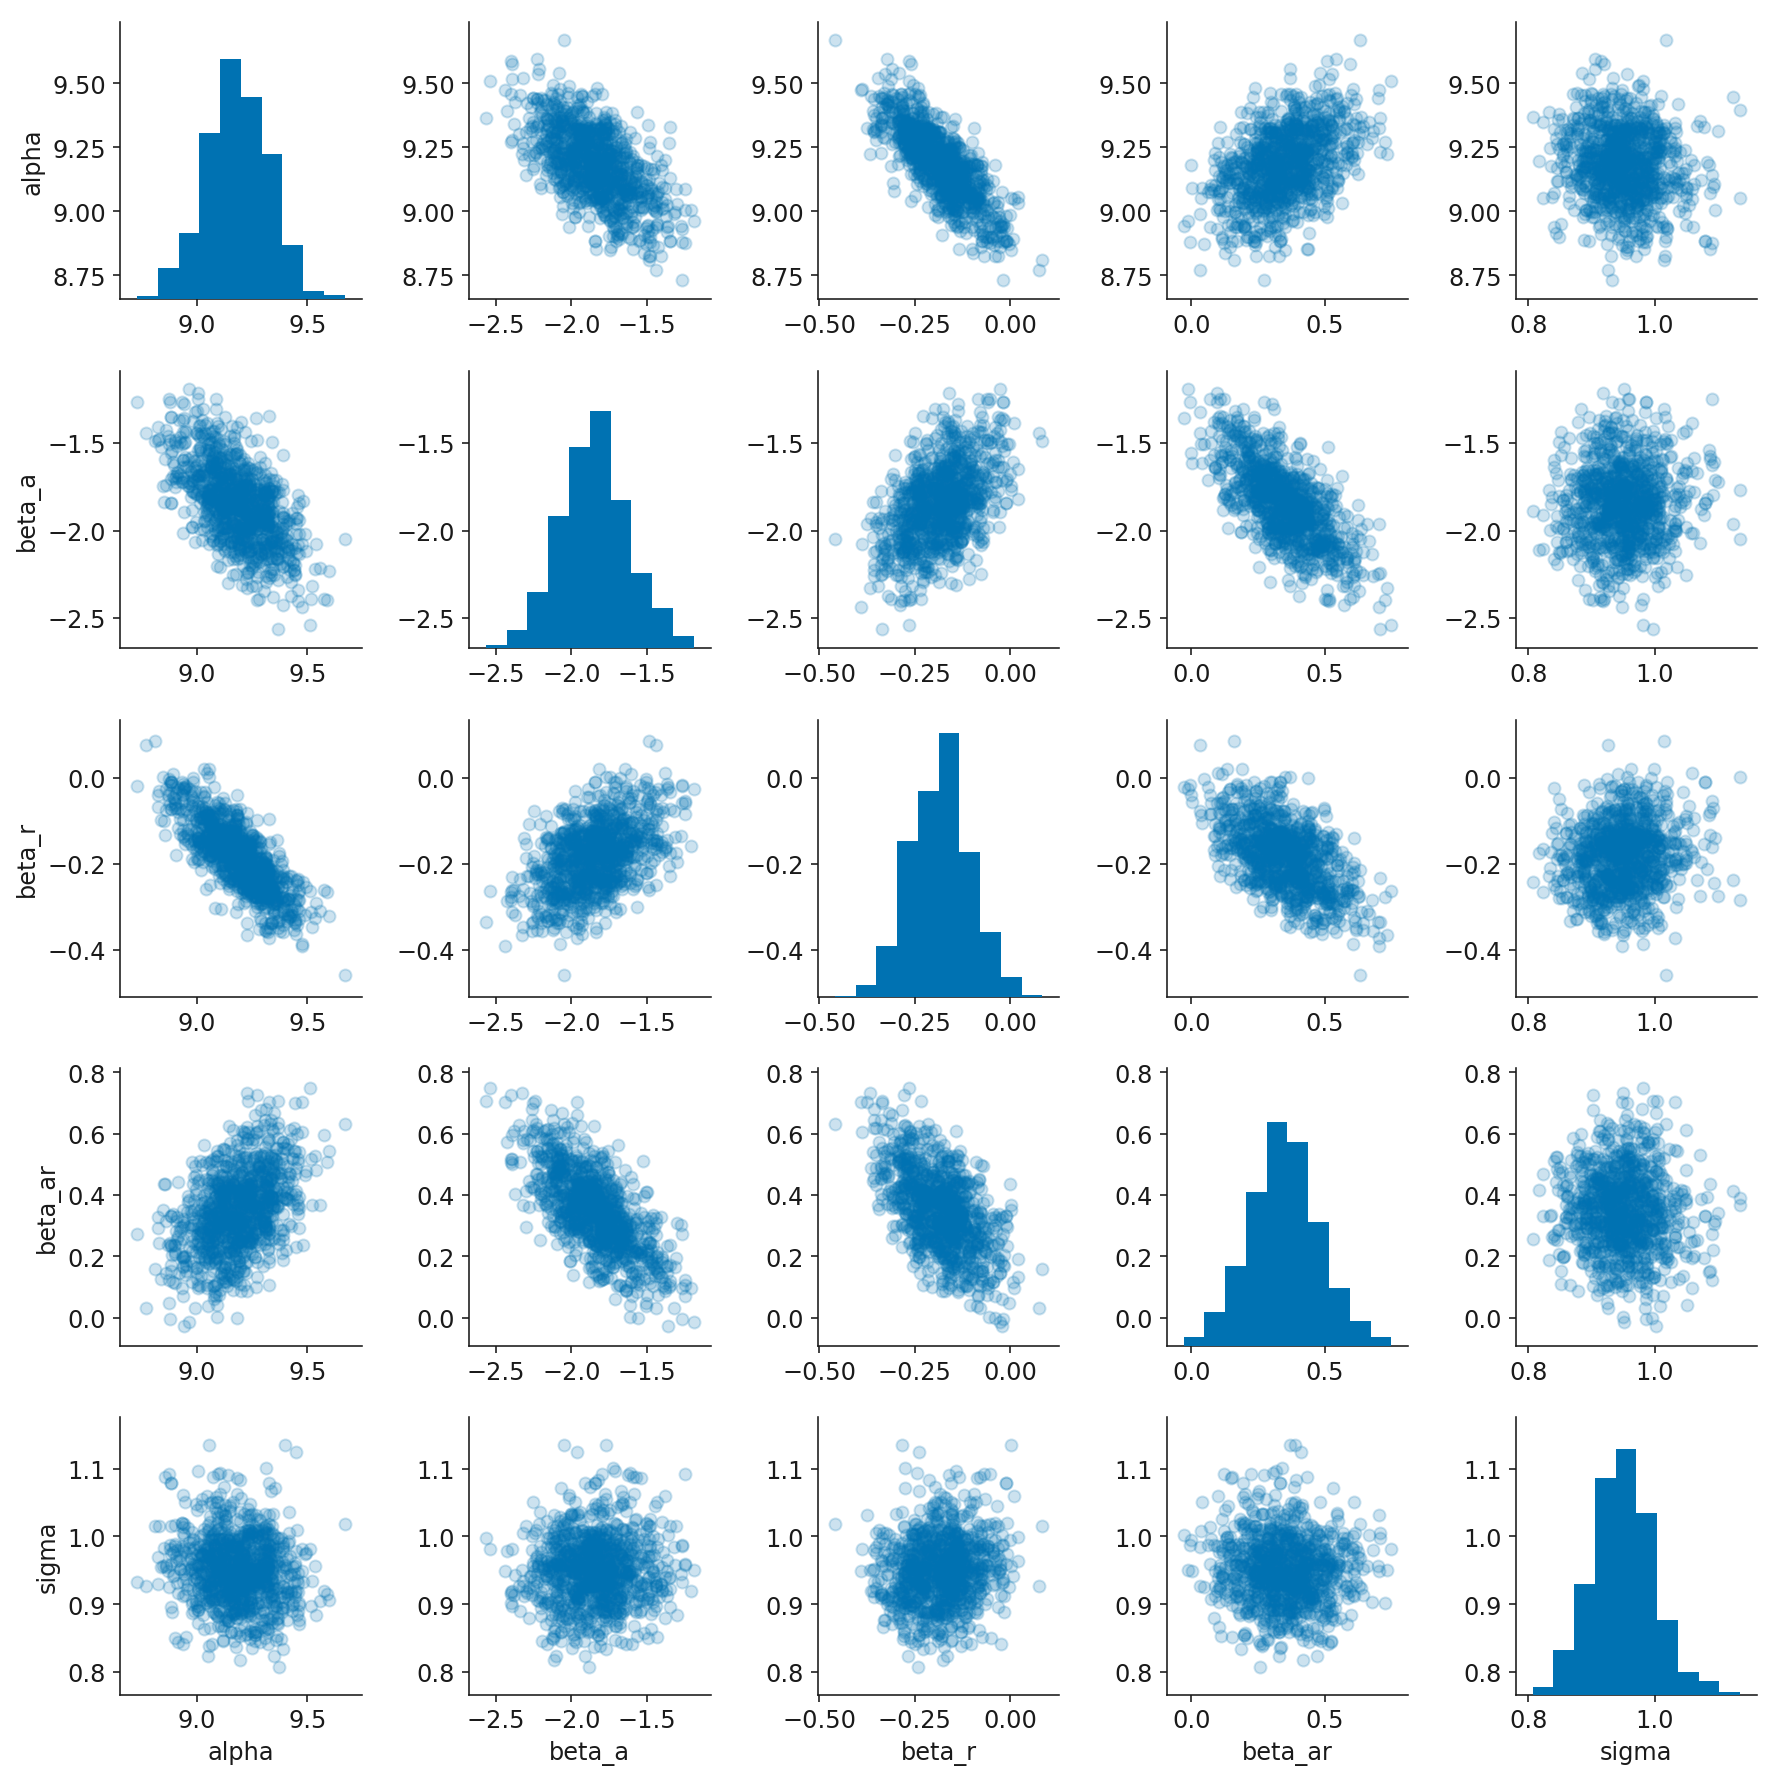

In [11]:
sns.pairplot(log_gdp_df, plot_kws={'alpha': 0.2, 'edgecolor': None});

In [12]:
log_gdp_df.corr().round(2)

,alpha,beta_a,beta_r,beta_ar,sigma
alpha,1.00,-0.60,-0.79,0.45,-0.13
beta_a,-0.60,1.00,0.49,-0.70,0.05
beta_r,-0.79,0.49,1.00,-0.57,0.13
beta_ar,0.45,-0.70,-0.57,1.00,-0.06
sigma,-0.13,0.05,0.13,-0.06,1.00


Note the relatively strong correlations between most of the coefficients. 

In [13]:
grid_rugged = np.linspace(0, 6.5, 100)

def get_mu_hpds_rugged(trace_df, grid, weights):
    mu_means = np.zeros(len(grid))
    mu_hpds = np.zeros((len(grid), 2))

    for i, value in enumerate(grid):
        gammas = (
            trace_df['beta_r'] + trace_df['beta_ar'] * weights['cont_africa']
        )
        mus = (
            trace_df['alpha'] 
            + gammas * value
            + trace_df['beta_a'] * weights['cont_africa']
        )

        mu_means[i] =  mus.mean()
        mu_hpds[i, :] = pm.hpd(mus, 0.11)
    return mu_means, mu_hpds, gammas

mu_means_africa, mu_hpds_africa, gammas_africa = get_mu_hpds_rugged(
    log_gdp_df, grid_rugged, {'cont_africa': 1})

mu_means_other, mu_hpds_other, gammas_other = get_mu_hpds_rugged(
    log_gdp_df, grid_rugged, {'cont_africa': 0})

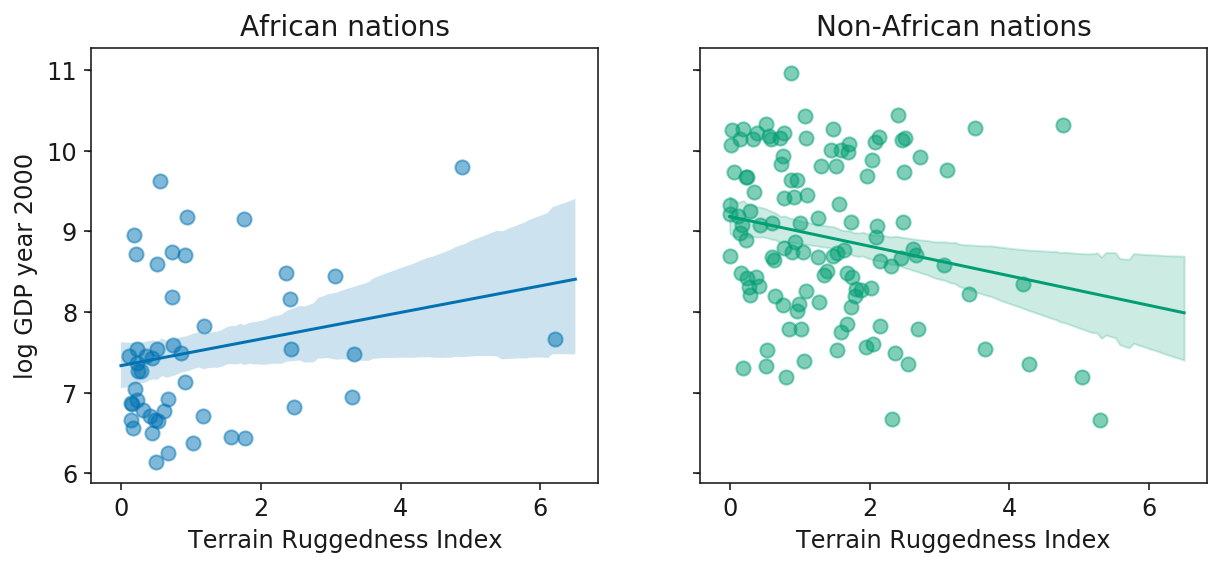

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
dd.loc[dd.cont_africa == 1].plot(x='rugged', y='log_gdp', ax=ax0, 
                                 kind='scatter', s=50, color=pal[0], alpha=0.5)
ax0.plot(grid_rugged, mu_means_africa)
ax0.fill_between(grid_rugged, mu_hpds_africa[:, 0], mu_hpds_africa[:, 1], alpha=0.2)
ax0.set_ylabel('log GDP year 2000')
ax0.set_title('African nations', fontsize=14)
ax0.set_xlabel('Terrain Ruggedness Index')

dd.loc[dd.cont_africa == 0].plot(x='rugged', y='log_gdp', ax=ax1, 
                                 kind='scatter', s=50, color=pal[1], alpha=0.5)
ax1.plot(grid_rugged, mu_means_other, c=pal[1])
ax1.fill_between(grid_rugged, mu_hpds_other[:, 0], mu_hpds_other[:, 1], color=pal[1], alpha=0.2)
ax1.set_title('Non-African nations', fontsize=14)
ax1.set_xlabel('Terrain Ruggedness Index')

plt.show()

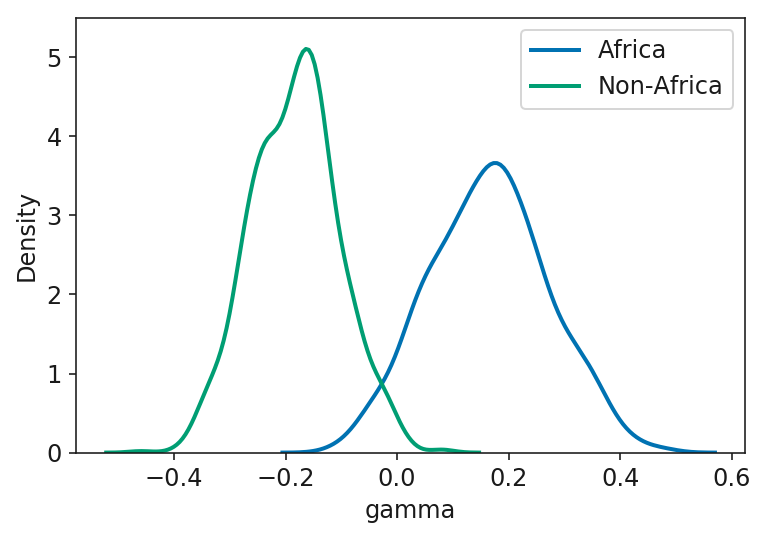

In [15]:
sns.kdeplot(gammas_africa, label='Africa', linewidth=2)
sns.kdeplot(gammas_other, label='Non-Africa', linewidth=2)
plt.ylim(0, 5.5)
plt.xlabel('gamma')
plt.ylabel('Density')
plt.show()

In [18]:
(gammas_africa - gammas_other < 0).mean()

0.004

The probability that the slope gamma is greater for African countries is 0.996. This is **different from the area of the overlap of the two curves** above. 

### Continuous interactions

In [24]:
tulips = pd.read_csv('data/tulips.csv', sep=';')

# center water and shade to improve estimation
tulips['water_c'] = tulips['water'] - tulips['water'].mean()
tulips['shade_c'] = tulips['shade'] - tulips['shade'].mean()

tulips.head(2)

,bed,water,shade,blooms,water_c,shade_c
0,a,1,1,0.0,-1.0,-1.0
1,a,1,2,0.0,-1.0,0.0


The outcome variable is `blooms` (the size of blooms of tulips, grown in greenhourses). The explanatory variables are `water_c`, `shade_c` and an interaction between the two. 

Note: the author calls this a continuous interaction, but the two explanatory variables are actually ordered categorical variables. 

In [26]:
tulips.shade_c.value_counts()

 1.0    9
 0.0    9
-1.0    9
Name: shade_c, dtype: int64

In [27]:
tulips.water_c.value_counts()

 1.0    9
 0.0    9
-1.0    9
Name: water_c, dtype: int64

We fit two models, one without interaction, and one with the interaction, and compare the two. 

In [31]:
with pm.Model() as no_interact_model:
    alpha = pm.Normal('alpha', mu=130, sd=100)
    beta_water = pm.Normal('beta_water', mu=0, sd=100)
    beta_shade = pm.Normal('beta_shade', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    
    mu = (
            alpha 
            + beta_water * tulips.water_c 
            + beta_shade * tulips.shade_c
    )
    blooms_hat = pm.Normal('blooms_hat', mu, sigma, 
                           observed=tulips.blooms)
    # add starting values for the chain to improve estimation
    no_interact_trace = pm.sample(
        draws=1000, 
        start={'beta_water': 0, 'beta_shade': 0, 
               'alpha': tulips.blooms.mean(), 
               'sigma': tulips.blooms.std()}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/nshenkov/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1500/1500 [00:02<00:00, 722.13it/s]


In [41]:
with pm.Model() as interact_model:
    alpha = pm.Normal('alpha', mu=130, sd=100)
    beta_water = pm.Normal('beta_water', mu=0, sd=100)
    beta_shade = pm.Normal('beta_shade', mu=0, sd=100)
    beta_ws = pm.Normal('beta_ws', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    
    mu = (
            alpha 
            + beta_water * tulips.water_c 
            + beta_shade * tulips.shade_c
            + beta_ws * tulips.water_c * tulips.shade_c
    )
    blooms_hat = pm.Normal('blooms_hat', mu, sigma, 
                           observed=tulips.blooms)
    # add starting values for the chain to improve estimation
    interact_trace = pm.sample(
        draws=1000, 
        start={'beta_water': 0, 'beta_shade': 0, 'beta_ws': 0,
               'alpha': tulips.blooms.mean(), 
               'sigma': tulips.blooms.std()}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/nshenkov/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1500/1500 [00:02<00:00, 624.19it/s]


In [42]:
no_interact_df = pm.trace_to_dataframe(no_interact_trace)
interact_df = pm.trace_to_dataframe(interact_trace)

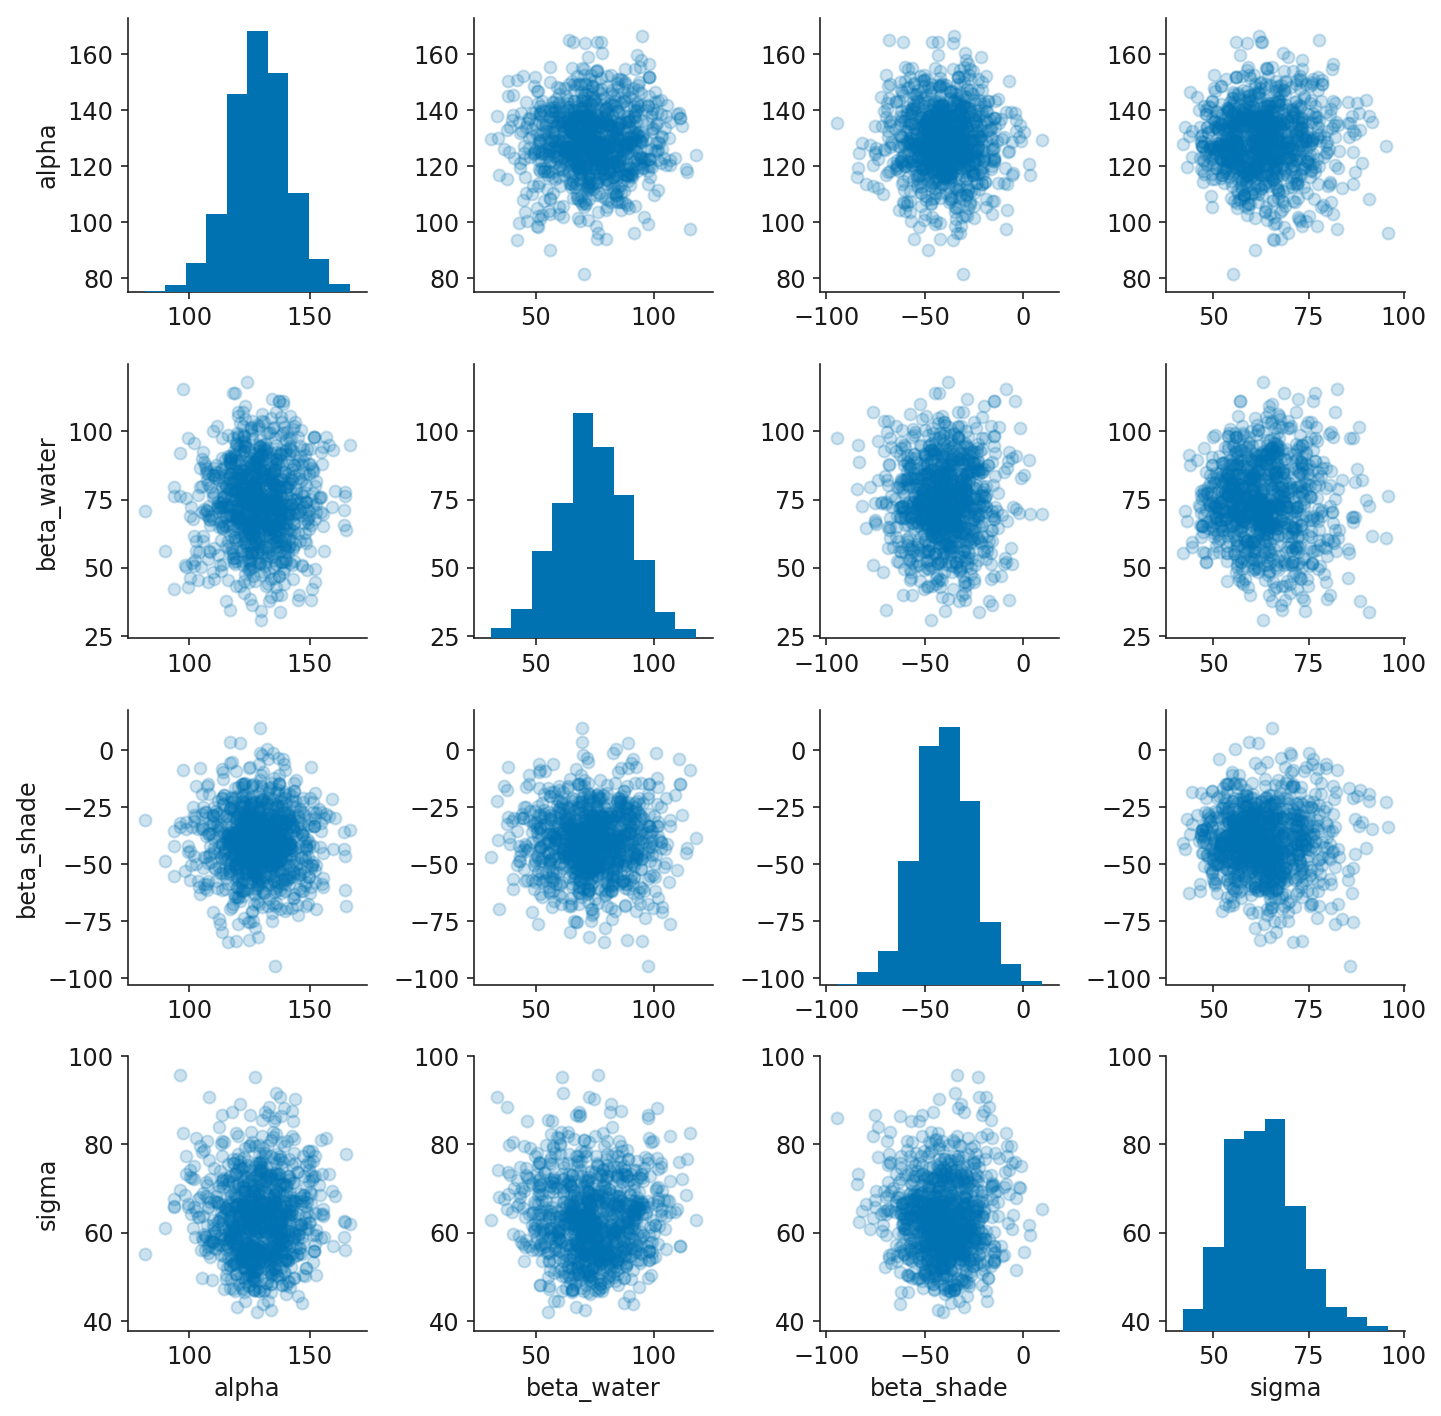

In [38]:
sns.pairplot(no_interact_df, plot_kws={'alpha': 0.2, 'edgecolor': None});

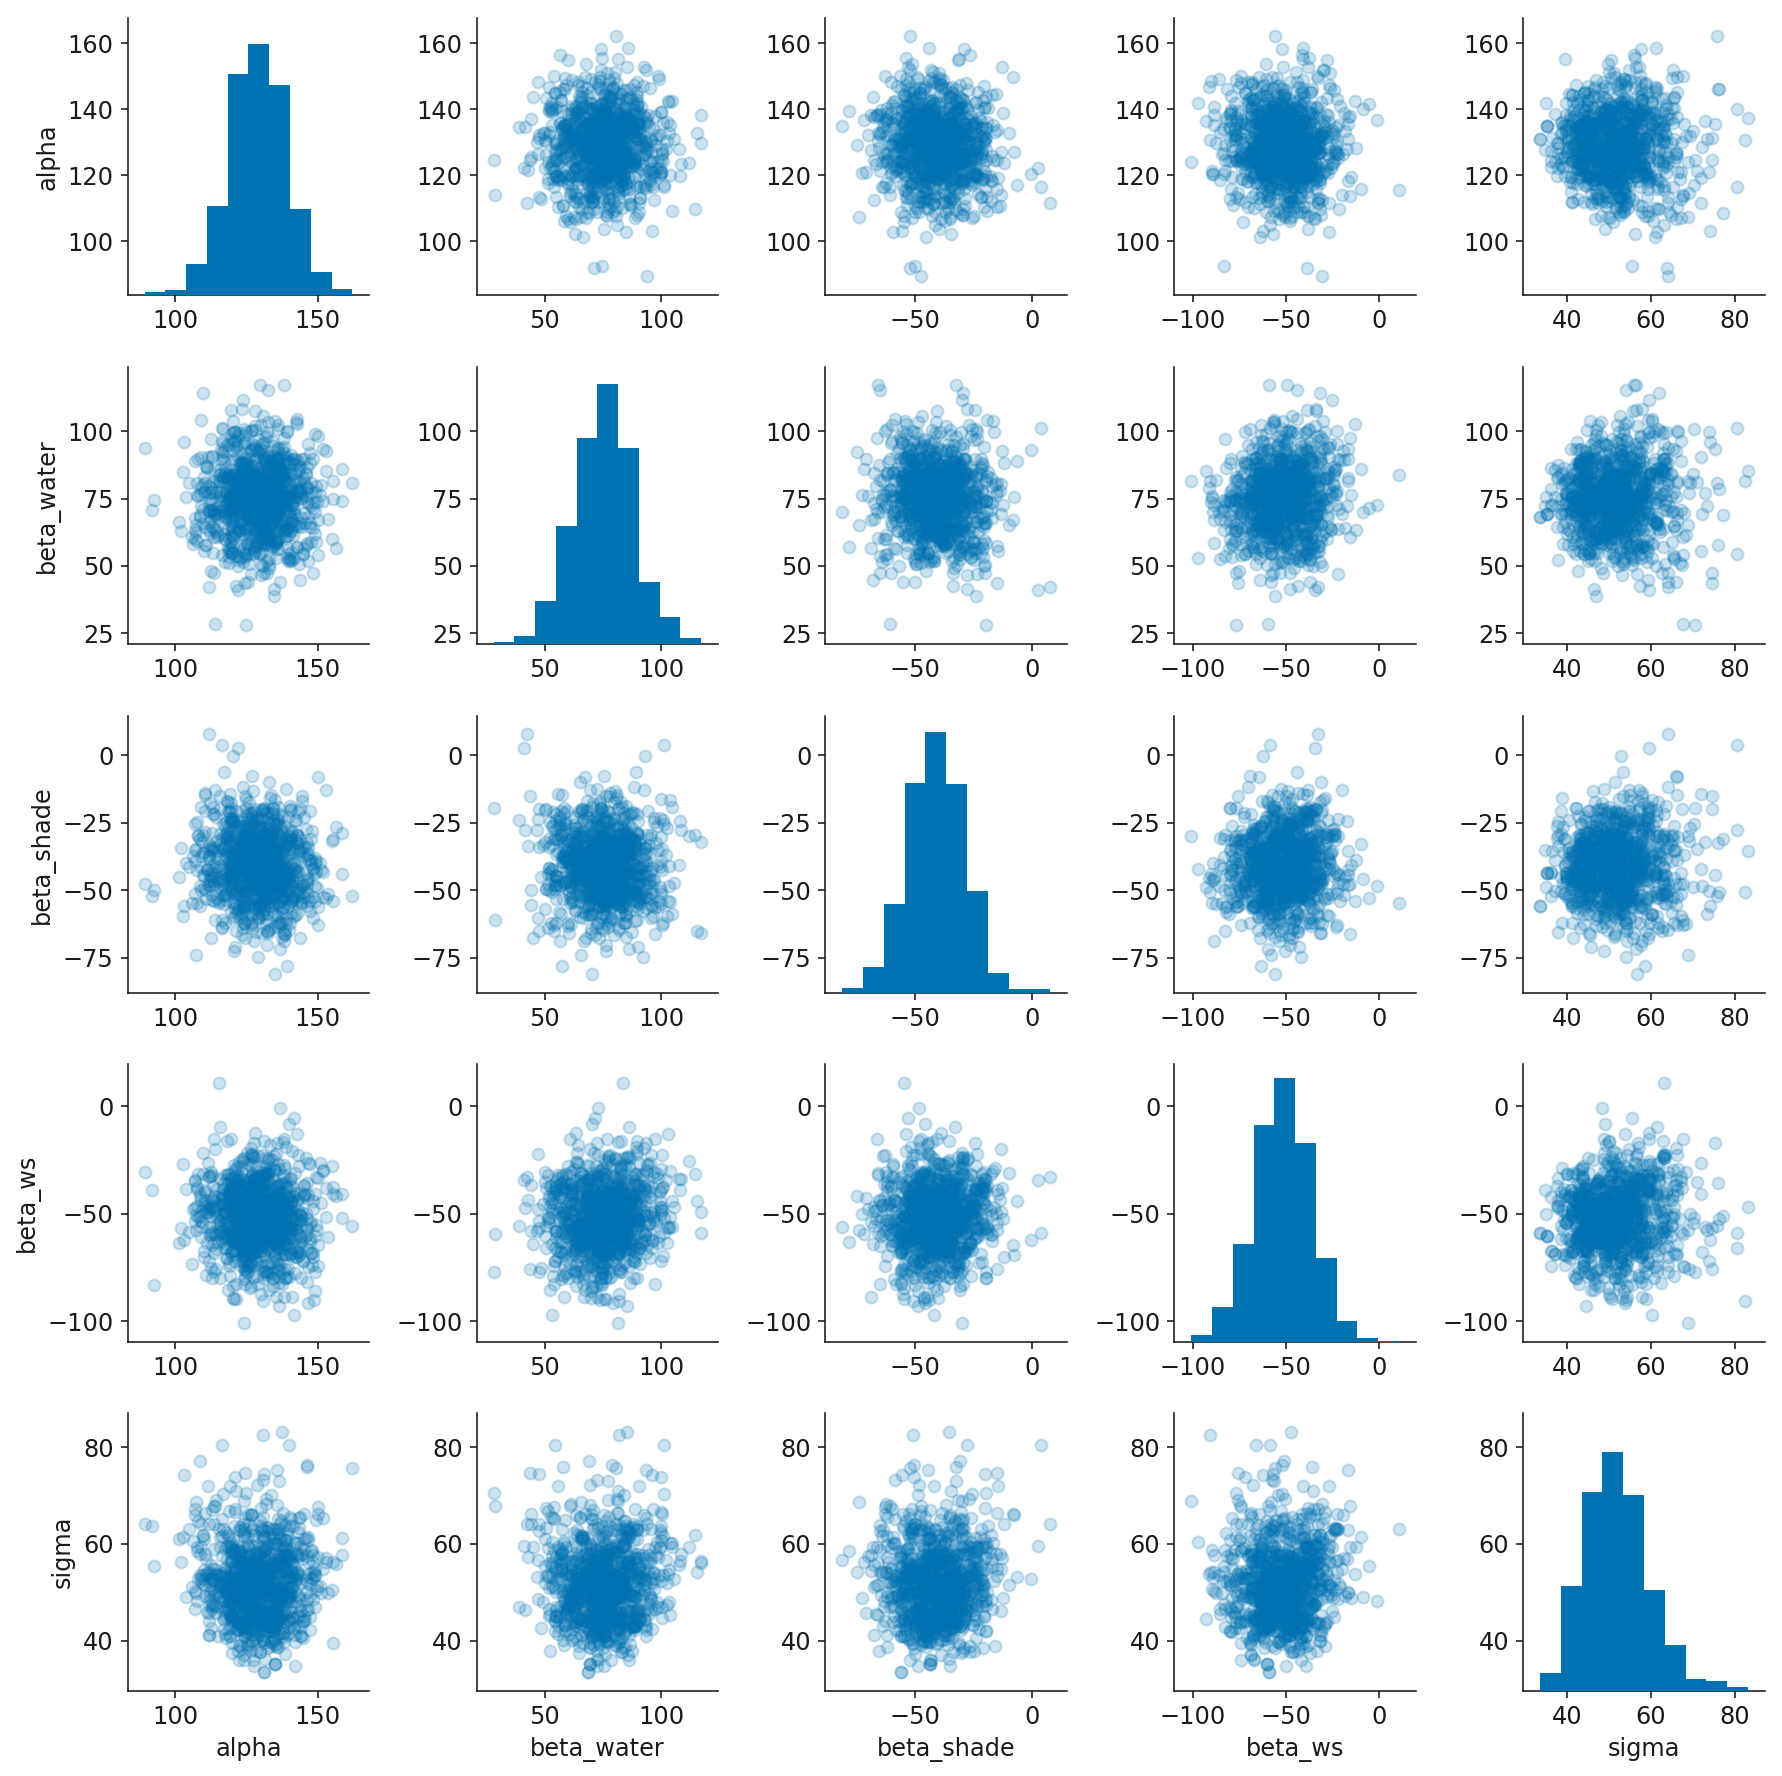

In [43]:
sns.pairplot(interact_df, plot_kws={'alpha': 0.2, 'edgecolor': None});

#### Use WAIC to compare models. 

See Chapter 6 for details on WAIC. Soon to come as a notebook!

The basic idea is that the smaller the WAIC, the better the model is. 

In [44]:
df_comp_WAIC = pm.compare((no_interact_trace, interact_trace), 
                          (no_interact_model, interact_model))
df_comp_WAIC

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,293.49,4.48,0,1,7.41,0,1
0,303.67,3.7,10.18,0,7,5.98,1


The interaction model has a lower WAIC, and the entire weight is placed on it. 

#### Show model estimates

In [50]:
pm.summary(interact_trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  129.017          10.151           0.337            [108.943, 148.402]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  108.983        122.404        129.129        135.961        148.557


beta_water:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  75.148           12.741           0.419            [51.688, 100.812]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  51.191         66.820         75.515         83.633         100.380


beta_shade:

  Mean             SD               MC Error         95% HPD interval
  ----

### Triptych plot

In [56]:
grid = np.linspace(-1, 1, 100)

def get_mu_hpds_tulips(trace_df, grid, weights):
    mu_means = np.zeros(len(grid))
    mu_hpds = np.zeros((len(grid), 2))

    
    mu = (
            alpha 
            + beta_water * tulips.water_c 
            + beta_shade * tulips.shade_c
            + beta_ws * tulips.water_c * tulips.shade_c
    )
    for i, shade_value in enumerate(grid):
        mus = (
            trace_df['alpha'] 
            + trace_df['beta_water'] * weights['water_c']
            + trace_df['beta_shade'] * shade_value 
        )
        
        # handle the interaction effect
        if 'beta_ws' in trace_df.columns:
            mus = mus + trace_df['beta_ws'] * weights['water_c'] * shade_value

        mu_means[i] =  mus.mean()
        mu_hpds[i, :] = pm.hpd(mus, 0.11)
    return mu_means, mu_hpds

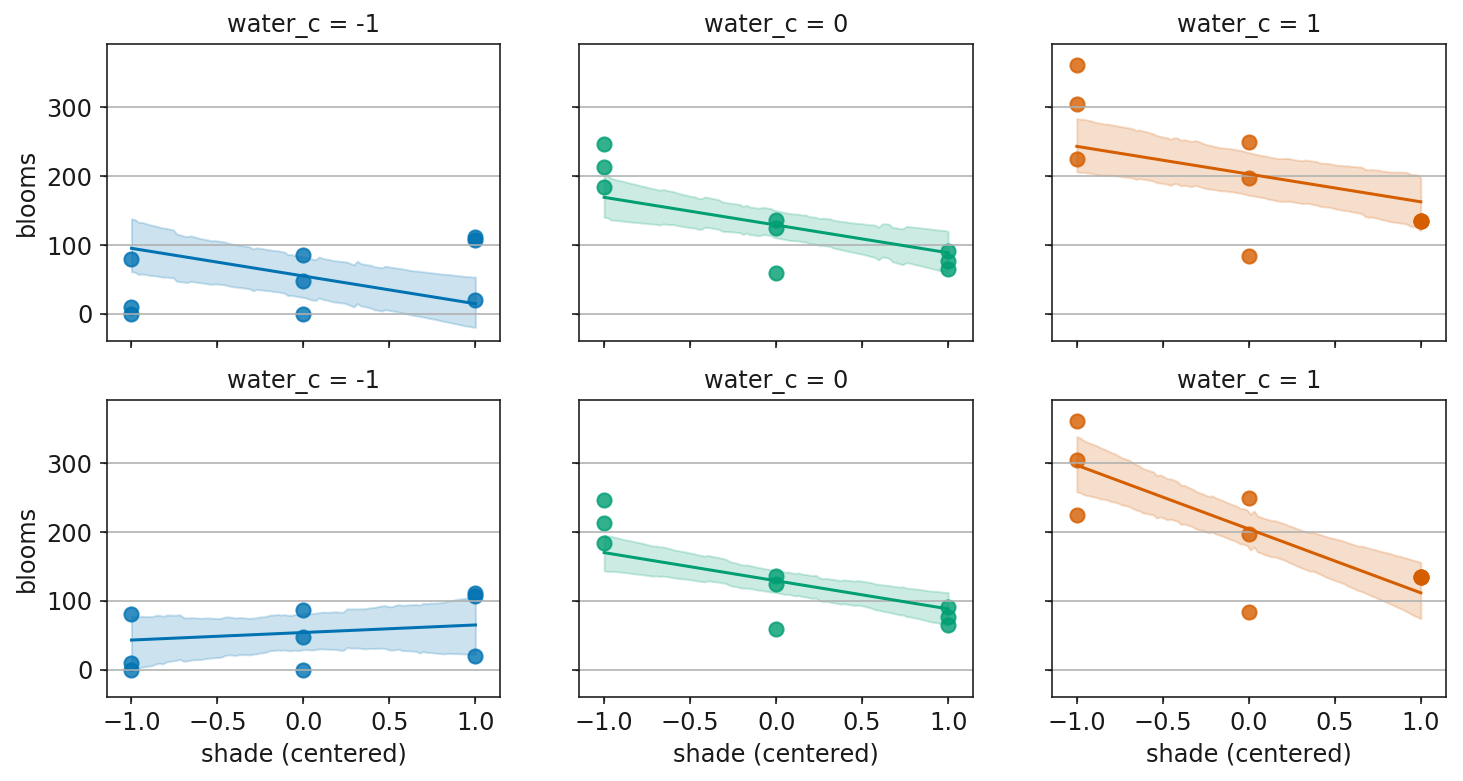

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

for i, trace_df in enumerate([no_interact_df, interact_df]):
    for j, water_c_value in enumerate([-1, 0, 1]):
        ax = axes[i, j]
        weights = {'water_c': water_c_value}
        mu_means, mu_hpds = get_mu_hpds_tulips(trace_df, grid, weights)
        
        tulips.loc[tulips.water_c == water_c_value].plot(
            x='shade_c', y='blooms', ax=ax, kind='scatter', 
            s=50, color=pal[j], alpha=0.8
        )
        ax.plot(grid, mu_means, c=pal[j])
        ax.fill_between(grid, mu_hpds[:, 0], mu_hpds[:, 1], color=pal[j], alpha=0.2)
        ax.set_ylabel('blooms')
        ax.set_title('water_c = {}'.format(water_c_value))
        ax.set_xlabel('shade (centered)')
        ax.grid('on', axis='y')


Top row: model without interaction. All slopes are identical. Bottom row: with interaction, the slopes are different for each value of `water_c`.